## 지도 시각화

In [1]:
# 필요한 라이브러리 import

import folium
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager,rc
import requests
import json

In [2]:
# 차트 폰트 설정 및 글자 깨짐 설정

font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
rc('font',family=font_name)
plt.rcParams['font.size'] = 14
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus']=False

#### 데이터 전처리 (1)
- 'brand'컬럼 추가 : 'store'컬럼에서 브랜드명만 추출

In [3]:
# 지도 시각화를 위한 데이터 전처리(store-> brand 분리)

emart_df=pd.read_csv('C:/MartRepository/4Mart/data/Emart_info.csv',encoding='utf-8')
lotte_df=pd.read_csv('C:/MartRepository/4Mart/data/lotte.csv',encoding='utf-8')
home_df=pd.read_csv('C:/MartRepository/4Mart/data/Homeplus_shop_info_loc4.csv',encoding='utf-8')
top_df=pd.read_csv('C:/MartRepository/4Mart/data/topmart_shop_info_loc.csv',encoding='utf-8')
mart_df=pd.concat([lotte_df, emart_df,home_df,top_df],axis=0)
mart_df.to_csv('./mart.csv',encoding='utf-8',index=False)
mart_df = pd.read_csv('./mart.csv',encoding='utf-8')
mart_df['brand']=mart_df['store'].str.split().str[0]
mart_df=mart_df[['brand','store','address','Latitude','Longitude','tel']]
mart_df.to_csv('./mart2.csv',encoding='utf-8',index=False)
mart_df['city']=mart_df['address'].str.split().str[0]
mart_df=mart_df[['brand','store','city','address','Latitude','Longitude','tel']]
mart_df

brand            store   city                                 address  \
0    롯데마트     롯데마트 TRU동부산점  부산광역시      부산광역시 기장군 기장읍 기장해안로 147 롯데몰동부산점 3층   
1    롯데마트      롯데마트 TRU파주점    경기도  경기도 파주시 문발로 302 A블럭 3층(문발동, 롯데프리미엄아울렛)   
2    롯데마트  롯데마트 marketD수원점    경기도                경기도 수원시 권선구 세화로 134 롯데마트   
3    롯데마트         롯데마트 강변점  서울특별시               서울특별시 광진구 광나루로56길 85 롯데마트   
4    롯데마트         롯데마트 거제점   경상남도                 경상남도 거제시 서간도길 9-9 (옥포동)   
..    ...              ...    ...                                     ...   
455   탑마트         탑마트 서진주점   경상남도             경상남도 진주시 새평거로 136 (평거동 921)   
456   탑마트          탑마트 대구점  대구광역시         대구광역시 중구 중앙대로 66길 20 (효성해링턴 지하)   
457   탑마트         탑마트 물금역점   경상남도         경상남도 양산시 물금읍 물금중앙길 18 (구, 물금시장)   
458   탑마트        탑마트 경주용강점   경상북도                 경상북도 경주시 산업로 4348 (용강동)   
459   탑마트          탑마트 부곡점  부산광역시            부산광역시 금정구 부곡동 79 (부곡동 333-1)   

      Latitude   Longitude             tel  
0    35.218819  129.231369    051-922-2500  
1    37.720410  126.693622    031-960-2750  
2    37.265378  126.995983   031-8067-2500  
3    37.534937  127.095709    02-3424-2500  
4    34.888501  128.689184    055-641-2500  
..         ...         ...             ...  
455  35.181392  128.069798    055)743-6300  
456  35.862074  128.594685    053)251-5000  
457  35.309926  128.984952    055-387-3008  
458  35.870536  129.231939  054)744-5501~2  
459  35.223140  129.090565  051)583-1501~2  

[460 rows x 7 columns]

#### CHART 1 (seaborn)
- 위/경도별 마트 분포를 산점도로 확인.

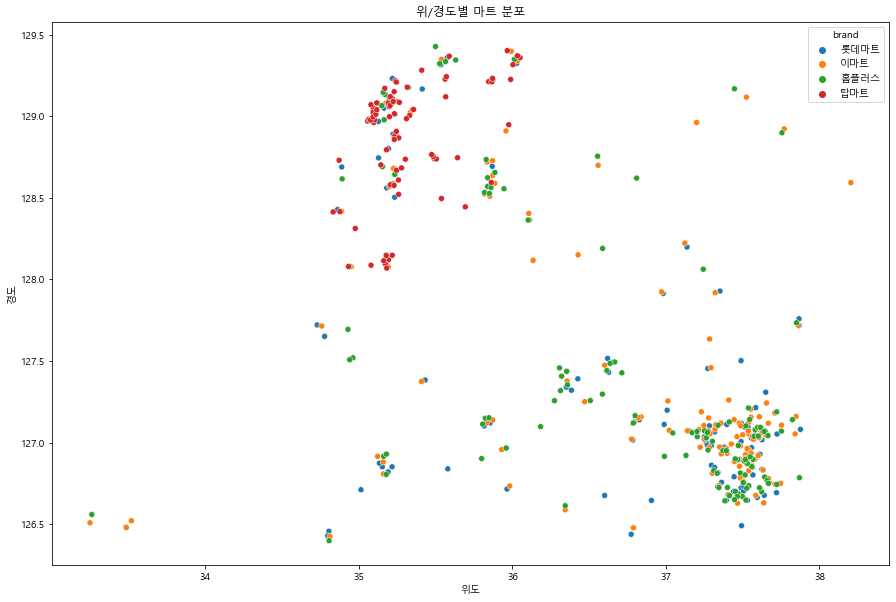

In [4]:
# 위/경도별 마트 분포 -> 서울/경기권, 부산/경상권에 밀집되어있는 것을 확인 가능

plt.figure(figsize=(15, 10))
chart3 = sns.scatterplot(data=mart_df, x="Latitude", y="Longitude", hue="brand")
chart3.set_title('위/경도별 마트 분포')
chart3.set_xlabel('위도')
chart3.set_ylabel('경도')
plt.show()

#### jointplot

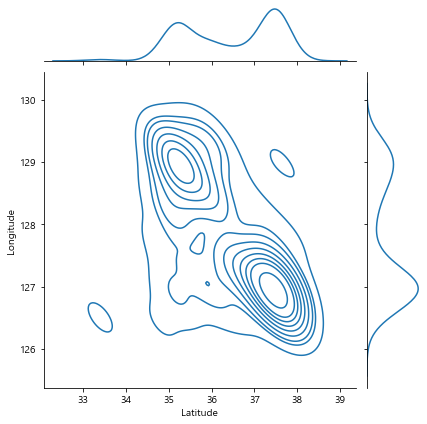

In [5]:
# 위경도별 마트 분포 -> 서울/경기권, 부산/경상권에 밀집되어있는 것을 확인 가능

sns.jointplot(data=mart_df, x="Latitude", y="Longitude", kind="kde")
plt.show()

### Choropleth map
- geo.json 파일 이용 -> 마트별 분포도를 지도에 시각화

#### 데이터 전처리(2)
- 시(도)별로 그룹핑 : 시(도)별 마트 갯수 df 생성

In [6]:
# 데이터처리 -> 구별로 그룹핑

df_mart_vs = mart_df.groupby(["brand", "city"])["city"].count()
df_mart_vs.head()

brand  city 
롯데마트   강원도       3
       경기도      30
       경상남도     12
       경상북도      3
       광주광역시     4
Name: city, dtype: int64

In [7]:
# reset_index 로  컬럼 생성

df_mart_vs = df_mart_vs.reset_index(name='count')
df_mart_vs.head()

brand   city  count
0  롯데마트    강원도      3
1  롯데마트    경기도     30
2  롯데마트   경상남도     12
3  롯데마트   경상북도      3
4  롯데마트  광주광역시      4

In [9]:
#  pivot_table 로 변환

pivot = pd.pivot_table(data=df_mart_vs,
               index=["brand", "city"], 
               values="count")
pivot.head()

count
brand city        
롯데마트  강원도        3
      경기도       30
      경상남도      12
      경상북도       3
      광주광역시      4

In [10]:
# 지오제이슨 파일 확인

geo_path = 'C:/MartRepository/4Mart/Emart/TL_SCCO_CTPRVN.json'
geo_path

with open(geo_path, encoding='utf-8') as file:
    geo_path = json.load(file)

geo_path['features'][3]['properties']

{'CTPRVN_CD': '47', 'CTP_ENG_NM': 'Gyeongsangbuk-do', 'CTP_KOR_NM': '경상북도'}

In [15]:
# [ 4마트 ] 위도 & 경도_평균 

lat = mart_df['Latitude'].mean()
long = mart_df['Longitude'].mean()
(lat, long)

(36.42794226152174, 127.71403986913046)

##### 이마트

In [11]:
# 이마트 데이터 호출

Emart_geo = df_mart_vs[df_mart_vs["brand"] == "이마트"].copy()
Emart_geo.head()

brand   city  count
16   이마트    강원도      6
17   이마트    경기도     45
18   이마트   경상남도      7
19   이마트   경상북도      9
20   이마트  광주광역시      3

In [14]:
# 이마트

m = folium.Map([lat, long], zoom_start=7)

folium.Choropleth(
    geo_data=geo_path,
    name='choropleth',
    data=Emart_geo,
    columns=['city', 'count'],
    key_on='properties.CTP_KOR_NM',
    fill_color='Set2',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='이마트 매장수'
).add_to(m)

m

##### 홈플러스

In [16]:
# 홈플러스 데이터 호출

homeplus_geo = df_mart_vs[df_mart_vs["brand"] == "홈플러스"].copy()
homeplus_geo.head()

brand   city  count
38  홈플러스    강원도      4
39  홈플러스    경기도     32
40  홈플러스   경상남도      8
41  홈플러스   경상북도      8
42  홈플러스  광주광역시      3

In [35]:
# 홈플러스

m = folium.Map([lat, long], zoom_start=7)

folium.Choropleth(
    geo_data=geo_path,
    name='choropleth',
    data=homeplus_geo,
    columns=['city', 'count'],
    key_on='properties.CTP_KOR_NM',
    fill_color='Pastel1',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='홈플러스 매장수'
).add_to(m)

m

##### 롯데마트

In [36]:
# 롯데마트 데이터 호출

lotte_geo = df_mart_vs[df_mart_vs["brand"] == "롯데마트"].copy()
lotte_geo.head()

brand   city  count
0  롯데마트    강원도      3
1  롯데마트    경기도     30
2  롯데마트   경상남도     12
3  롯데마트   경상북도      3
4  롯데마트  광주광역시      4

In [37]:
# 롯데마트

m = folium.Map([lat, long], zoom_start=7)

folium.Choropleth(
    geo_data=geo_path,
    name='choropleth',
    data=lotte_geo,
    columns=['city', 'count'],
    key_on='properties.CTP_KOR_NM',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='롯데마트 매장수'
).add_to(m)

m

##### 탑마트 

In [38]:
# 탑마트 데이터 호출

top_geo = df_mart_vs[df_mart_vs["brand"] == "탑마트"].copy()
top_geo.head()

brand   city  count
33   탑마트   경상남도     34
34   탑마트   경상북도     10
35   탑마트  대구광역시      2
36   탑마트  부산광역시     26
37   탑마트  울산광역시      5

In [39]:
# 탑마트

m = folium.Map([lat, long], zoom_start=7)

folium.Choropleth(
    geo_data=geo_path,
    name='choropleth',
    data=top_geo,
    columns=['city', 'count'],
    key_on='properties.CTP_KOR_NM',
    fill_color='PRGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='탑마트 매장수',
).add_to(m)

m